In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'polycentric') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel
import numpy as np
import pandas as pd
from syspy.skims import skims
from quetzal.io import excel

SQLalchemy is not installed. No support for SQL output.


In [3]:
training_folder = '../../'

In [4]:
sm = stepmodel.read_zippedpickles(training_folder + 'model/{scen}/distribution'.format(scen=scenario))
pt = stepmodel.read_zippedpickles(training_folder + 'model/{scen}/aon_pathfinder'.format(scen=scenario))

zone_to_transit: 100%|█████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 20.36it/s]


In [5]:
 # the scenario specific variables are read from the parameter file
var = excel.read_var(file='../../inputs/parameters.xlsx', scenario=scenario)

# monitoring

In [6]:
dict_area=sm.zones[['area']].to_dict('index') #TODO check 

pt.pt_los['area_origin']=pt.pt_los['origin'].apply(lambda i: dict_area[i]['area'])
pt.pt_los

coef = var['step_distribution']['pt_intrazonal_parameter'] #To calibrate
walk_speed = var['speed']['walk_on_road'] #km/h

import math

for element in pt.pt_los.index:
    if pt.pt_los['origin'][element]==pt.pt_los['destination'][element]:
        pt.pt_los['gtime'][element]=3600*coef*math.sqrt(pt.pt_los['area_origin'][element])/walk_speed

# Add X seconds to each OD

pt.pt_los['gtime'] = pt.pt_los['gtime'] + var['step_distribution']['pt_intrazonal_time']

Text(0.5, 1.0, 'PT captives distribution')

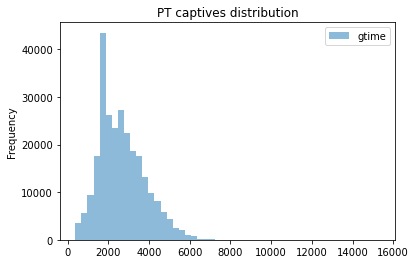

In [117]:
od = pd.merge(sm.volumes, pt.pt_los, on=['origin', 'destination'])
import matplotlib.pyplot as plt
plot = od[['gtime']].plot(kind='hist', weights=od['pt_captive'], bins=50, alpha=0.5)
plot.set_title('PT captives distribution')

In [118]:
df_zones = sm.zones[['latin_name', 'kebele']]
dict_zones_ind = df_zones.to_dict('index')
df_zones = df_zones.reset_index()
df_zones['latin_name'] = df_zones['latin_name'].dropna().apply(lambda s : s.replace("_", " "))
df_zones = df_zones.set_index('latin_name').dropna()
dict_zones = df_zones.to_dict('index')

In [119]:
df_zones = sm.zones[['kebele','latin_name','kebele_latin']].rename(columns={'kebele_latin':'kebele latin'}).reset_index().set_index('latin_name')
#dict_zones = df_zones.to_dict('index')

trips = pd.read_csv(r'../../../quetzal_dire_dawa/inputs/clean_trips.csv')

trips['departure_time'] = trips['departure_time'].apply(lambda dt_string: pd.Timedelta(dt_string))

trips_hpm=trips.loc[
    (trips['departure_time']>=pd.Timedelta('7 hours'))
    & (trips['departure_time']<=pd.Timedelta('7 hours 55 minutes'))
]

trips_vol = pd.DataFrame(trips_hpm.groupby(['zone origin', 'zone destination'])['weight'].sum()).reset_index().fillna(0)

trips_vol['zone origin']=trips_vol['zone origin'].apply(lambda s: s.replace("é", "e"))
trips_vol['zone destination']=trips_vol['zone destination'].apply(lambda s: s.replace("é", "e"))

trips_vol['zone origin']=trips_vol['zone origin'].apply(lambda s: dict_zones[s]['id'])
trips_vol['zone destination']=trips_vol['zone destination'].apply(lambda s: dict_zones[s]['id'])

### Distance distribution 

In [120]:
projected = sm.change_epsg(epsg=4326, coordinates_unit='degree')

euclidean = skims.euclidean(projected.zones).set_index(['origin', 'destination'])
intrazonal = 0.8
euclidean['km'] = euclidean['euclidean_distance']/1000 + intrazonal
euclidean.head()

Reprojecting model from epsg 20137 to epsg 4326: 100%|█████████████████████████████████| 33/33 [00:04<00:00,  7.86it/s]


,,euclidean_distance,x_origin,y_origin,x_destination,y_destination,km
origin,destination,,,,,,
zone_183,zone_183,0.000000,41.762530,9.591036,41.76253,9.591036,0.800000
k5_1_kutir_banba,zone_183,12272.721376,41.873976,9.580745,41.76253,9.591036,13.072721
zone_166,zone_183,2601.028131,41.779519,9.607363,41.76253,9.591036,3.401028
k8_giyorgis,zone_183,12739.802691,41.878569,9.596999,41.76253,9.591036,13.539803
zone_159,zone_183,6839.671921,41.809507,9.631512,41.76253,9.591036,7.639672


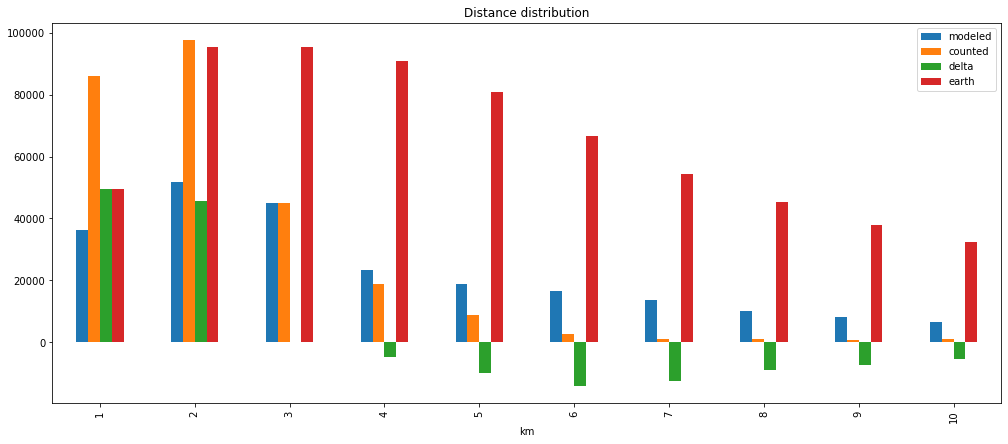

In [121]:
od_dist = pd.merge(sm.volumes, euclidean.reset_index(), on=['origin', 'destination'], how='outer')
#dict_zones_ind=df_zones.set_index('kebele_latin').to_dict('index')
od_dist['origin_kebele']=od_dist['origin'].apply(lambda i: dict_zones_ind[i]['kebele'])
od_dist['destination_kebele']=od_dist['destination'].apply(lambda j: dict_zones_ind[j]['kebele'])
od_dist = pd.merge(od_dist,trips_vol, left_on=['origin', 'destination'], right_on=['zone origin', 'zone destination'], how='outer')
#od_dist = od_dist.loc[od_dist['origin']!=od_dist['destination']] #only interzonal trips
trips_survey_dist=od_dist['weight'].sum()
od_dist['weight']=od_dist['weight'].apply(lambda m: m*od_dist['pt_captive'].sum()/trips_survey_dist) #normalized volumes
od_dist['km'] = od_dist['km'].apply(lambda s: round(s))
grouped_dist = od_dist.groupby('km')[['pt_captive', 'weight']].sum()
grouped_dist.rename(columns={'pt_captive':'modeled', 'weight':'counted'}, inplace=True)
grouped_dist['delta'] = grouped_dist['counted'].fillna(0) - grouped_dist['modeled'].fillna(0)
grouped_dist['earth'] = grouped_dist['delta'].cumsum()
import matplotlib.pyplot as plt
bars_plot_dist = grouped_dist[:10].plot(kind='bar', figsize=[17, 7], title='Distance distribution')

In [122]:
print('real dist mean =',(od_dist['km']*od_dist['weight']).sum()/od_dist['weight'].sum(),' ',
      'estimated dist mean =',(od_dist['km']*od_dist['pt_captive']).sum()/od_dist['pt_captive'].sum())

real dist mean = 2.233906334465357   estimated dist mean = 5.19336204061252


In [123]:
print('real pkm mean =',(od_dist['km']*od_dist['weight']).sum(),' ',
      'estimated pkm mean =',(od_dist['km']*od_dist['pt_captive']).sum())

real pkm mean = 588034.4887783211   estimated pkm mean = 1367056.4183807683


### Time distribution 

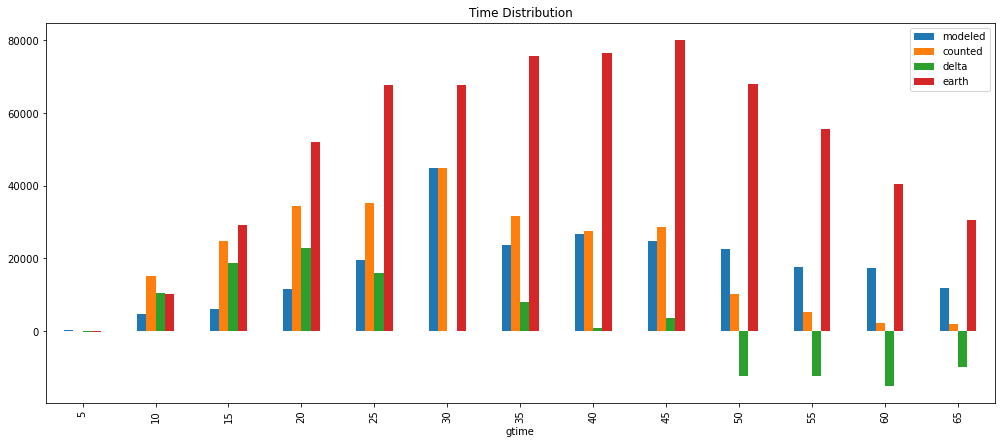

In [124]:
od = pd.merge(sm.volumes, pt.pt_los, on=['origin', 'destination'], how='outer')
#dict_zones_ind=df_zones.set_index('kebele_latin').to_dict('index')
od['origin_kebele']=od['origin'].apply(lambda i: dict_zones_ind[i]['kebele'])
od['destination_kebele']=od['destination'].apply(lambda j: dict_zones_ind[j]['kebele'])
od = pd.merge(od,trips_vol, left_on=['origin', 'destination'], right_on=['zone origin', 'zone destination'], how='outer')
trips_survey=od['weight'].sum()
od['weight']=od['weight'].apply(lambda m: m*od['pt_captive'].sum()/trips_survey) #normalized volumes
od['gtime'] = od['gtime'].apply(lambda s: 5*round(s/(5*60)))
#od = od.loc[od['origin']!=od['destination']] #only interzonal trips
grouped = od.groupby('gtime')[['pt_captive', 'weight']].sum()
grouped.rename(columns={'pt_captive':'modeled', 'weight':'counted'}, inplace=True)
grouped['delta'] = grouped['counted'].fillna(0) - grouped['modeled'].fillna(0)
grouped['earth'] = grouped['delta'].cumsum()
import matplotlib.pyplot as plt
bars_plot_time = grouped[:13].plot(kind='bar', figsize=[17, 7], title='Time Distribution')

In [125]:
print('real gtime mean =',(od['gtime']*od['weight']).sum()/od['weight'].sum(),' ',
      'estimated gtime mean =',(od['gtime']*od['pt_captive']).sum()/od['pt_captive'].sum())

real gtime mean = 30.856726323732207   estimated gtime mean = 44.353287097515114


In [126]:
print('real trips =',trips_survey,' ','estimated trips =',od['pt_captive'].sum())

real trips = 96153.71914552477   estimated trips = 263231.48813625437


In [77]:
grouped['earth'].apply(lambda i : abs(i)).sum()

696225.2527381711

In [78]:
grouped['earth'].sum()

695677.8752490663

### Volume distribution by kebele 

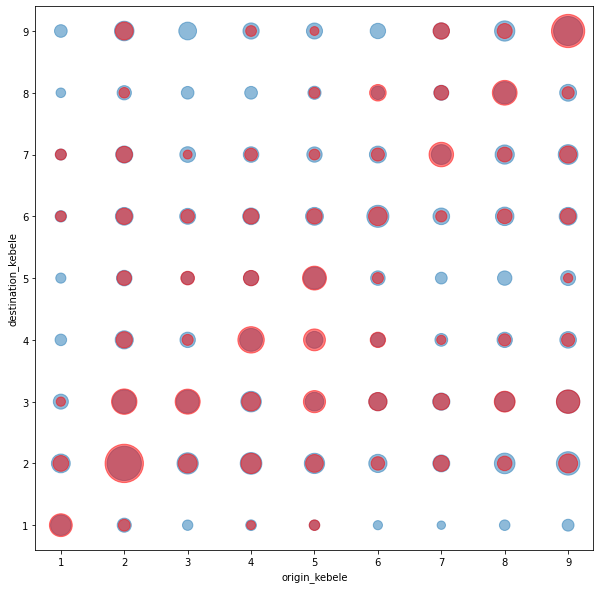

In [19]:
scale = 0.01
power = 0.5

r=od.groupby(['origin_kebele', 'destination_kebele'], as_index=False)[['pt_captive','weight']].sum()
ax = r.plot(kind='scatter', x='origin_kebele', y='destination_kebele', 
            s=np.power(r['pt_captive']/scale, power), alpha=0.5, figsize=[10 ,10])
plot = r.plot(kind='scatter', x='origin_kebele', y='destination_kebele', 
              s=np.power(r['weight']/scale, power), alpha=0.5, color='red', ax = ax)

## Export

In [20]:
calibration = pd.Series({
    'Counted trips' : trips_survey,
    'Modeled trips' : od['pt_captive'].sum(),
    'Delta trips' : trips_survey-od['pt_captive'].sum(),
    'Counted average time' : (od['gtime']*od['weight']).sum()/od['weight'].sum(),
    'Modeled average time' : (od['gtime']*od['pt_captive']).sum()/od['pt_captive'].sum(),
    '"Earth" sum time' : grouped['earth'].apply(lambda i : abs(i)).sum(),
    'Counted average dist' : (od_dist['km']*od_dist['weight']).sum()/od_dist['weight'].sum(),
    'Modeled average dist' : (od_dist['km']*od_dist['pt_captive']).sum()/od_dist['pt_captive'].sum(),
    '"Earth" sum dist' : grouped_dist['earth'].apply(lambda i : abs(i)).sum()
})

calibration.to_excel(r'../../model/{scen}/calibration/calibration_{scen}.xlsx'.format(scen=scenario), sheet_name='distribution')

FileNotFoundError: [Errno 2] No such file or directory: '../../model/base1/calibration/calibration_base1.xlsx'

In [ ]:
dist_plot = bars_plot_dist.get_figure()
dist_plot.savefig(r'../../model/{scen}/calibration/distr_dist_{scen}.png'.format(scen=scenario), bbox_inches='tight')

In [ ]:
time_plot = bars_plot_time.get_figure()
time_plot.savefig(r'../../model/{scen}/calibration/distr_time_{scen}.png'.format(scen=scenario), bbox_inches='tight')

In [ ]:
kebele_dist = plot.get_figure()
kebele_dist.savefig(r'../../model/{scen}/calibration/distr_kebele_{scen}.png'.format(scen=scenario), bbox_inches='tight')

# END

In [ ]:
 end_of_notebook